# 5.3 Lab: [Cross-Validation](http://scikit-learn.org/0.17/modules/cross_validation.html#cross-validation-iterators) and the Bootstrap


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### scikit-learn이 Version 0.18로 되면서 여러 곳에 흩어져 있던 모델 평가/선택에 관련된 모듈들을 한 데 모으고 몇 가지 변화를 주었음 (scikit-learn Version 0.18 groups together formerly scattered modules related to model evaulation and selection). [참조/see](http://scikit-learn.org/stable/whats_new.html#version-0-18) 
#### 이 Notebook은(this notebook is based on) [scikit-learn 0.17](http://scikit-learn.org/0.17/model_selection.html#model-selection) 사용 

In [2]:
# Load data
# Auto = pd.read_csv("../Data/Auto.csv", na_values=['?']).dropna()
Auto = pd.read_csv("../Data/Auto.csv")

# 'horsepower' 열에 숫자가 아닌 행들을 제거, 'horsepower'열을 float로, Auto의 index를 1 .. 392로 
rows_select = Auto.horsepower.apply(lambda x: x.isnumeric())
Auto= Auto.loc[rows_select, :]
Auto.horsepower = np.float64(Auto.horsepower)    
Auto.index = range(1, len(Auto)+1)
Auto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 1 to 392
Data columns (total 9 columns):
mpg             392 non-null float64
cylinders       392 non-null int64
displacement    392 non-null float64
horsepower      392 non-null float64
weight          392 non-null int64
acceleration    392 non-null float64
year            392 non-null int64
origin          392 non-null int64
name            392 non-null object
dtypes: float64(4), int64(4), object(1)
memory usage: 26.1+ KB


In [3]:
Auto.tail()            

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
388,27.0,4,140.0,86.0,2790,15.6,82,1,ford mustang gl
389,44.0,4,97.0,52.0,2130,24.6,82,2,vw pickup
390,32.0,4,135.0,84.0,2295,11.6,82,1,dodge rampage
391,28.0,4,120.0,79.0,2625,18.6,82,1,ford ranger
392,31.0,4,119.0,82.0,2720,19.4,82,1,chevy s-10


## 5.3.1 The Validation Set Approach
### Train/Test split은 여러 방법으로 가능.  여기서는 scikit-learn이 제공하는 (we will be using) '[train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split)' 사용 

In [4]:
from sklearn.cross_validation import train_test_split, LeaveOneOut  # version 0.17 

X = Auto.horsepower.reshape(-1, 1)
y = Auto.mpg
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

In [5]:
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

from sklearn import metrics
print ("The MAE is: {:.3}".format( metrics.mean_absolute_error(y_test, y_pred) )  )  # (True, Predict) 순서  
print ("The MSE is: {:.3}".format( metrics.mean_squared_error(y_test, y_pred) )  )
print ("The RMSE is: {:.3}".format( np.sqrt( metrics.mean_squared_error(y_test, y_pred)))) 

The MAE is: 3.9
The MSE is: 24.8
The RMSE is: 4.98


#### 'horsepower'의 제곱, 세제곱을 feature로 쓴 경우의 Test Error (Test error for linear model with quadratic and cubic transformed 'horsepower')

In [6]:
X_poly = pd.concat([Auto.horsepower, np.power(Auto.horsepower, 2), np.power(Auto.horsepower, 3)], axis=1)
X_poly.columns = ['horsepower', 'hp_squared', 'hp_cubed']
X_poly.head()

,horsepower,hp_squared,hp_cubed
1,130.0,16900.0,2197000.0
2,165.0,27225.0,4492125.0
3,150.0,22500.0,3375000.0
4,150.0,22500.0,3375000.0
5,140.0,19600.0,2744000.0


In [7]:
# Quadratic Regression
X_2 = X_poly.loc[:, ['horsepower', 'hp_squared']]
y = Auto.mpg
X_train, X_test, y_train, y_test = train_test_split(X_2, y, test_size=0.5, random_state=1)
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
print ("The MAE is: {:.4}".format( metrics.mean_absolute_error(y_test, y_pred) )  )  # (True, Predict) 순서  
print ("The MSE is: {:.4}".format( metrics.mean_squared_error(y_test, y_pred) )  )
print ("The RMSE is: {:.4}".format( np.sqrt( metrics.mean_squared_error(y_test, y_pred)))) 

The MAE is: 3.244
The MSE is: 18.85
The RMSE is: 4.341


In [8]:
# Cubic regression
X_3 = X_poly.loc[:, ['horsepower', 'hp_squared', 'hp_cubed']]
y = Auto.mpg
X_train, X_test, y_train, y_test = train_test_split(X_3, y, test_size=0.5, random_state=1)
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
print ("The MAE is: {:.4}".format( metrics.mean_absolute_error(y_test, y_pred) )  )  # (True, Predict) 순서  
print ("The MSE is: {:.4}".format( metrics.mean_squared_error(y_test, y_pred) )  )
print ("The RMSE is: {:.4}".format( np.sqrt( metrics.mean_squared_error(y_test, y_pred)))) 

The MAE is: 3.245
The MSE is: 18.81
The RMSE is: 4.336


#### Train/Test split를 변화시키면서 1차, 2차, 3차 regression 들의 MSE를 본다 (we'll see changes in MSE as train/test split differs by setting different random_state's)

In [9]:
for randomstate in [1, 5, 1234]:
    print("\nrandom_seed = %d" % randomstate)
    for features in [1, 2, 3]:
        X = X_poly.iloc[:, :features]
        print(X.columns, end=" : ")
        y = Auto.mpg
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=randomstate)
        lr_model = LinearRegression()
        lr_model.fit(X_train, y_train)
        y_pred = lr_model.predict(X_test)
        print ("The MSE is: {:.4}".format( metrics.mean_squared_error(y_test, y_pred) )  )


random_seed = 1
Index(['horsepower'], dtype='object') : The MSE is: 24.8
Index(['horsepower', 'hp_squared'], dtype='object') : The MSE is: 18.85
Index(['horsepower', 'hp_squared', 'hp_cubed'], dtype='object') : The MSE is: 18.81

random_seed = 5
Index(['horsepower'], dtype='object') : The MSE is: 29.59
Index(['horsepower', 'hp_squared'], dtype='object') : The MSE is: 24.15
Index(['horsepower', 'hp_squared', 'hp_cubed'], dtype='object') : The MSE is: 24.1

random_seed = 1234
Index(['horsepower'], dtype='object') : The MSE is: 27.11
Index(['horsepower', 'hp_squared'], dtype='object') : The MSE is: 20.87
Index(['horsepower', 'hp_squared', 'hp_cubed'], dtype='object') : The MSE is: 20.9


## 5.3.3  [k-Fold](http://scikit-learn.org/0.17/modules/generated/sklearn.cross_validation.KFold.html#sklearn.cross_validation.KFold) Cross-Validation  
### K-Fold Cross-Validation으로 Regressor 평가
다음 cell은 10-Fold Cross-Validation 를 이용해 앞의 3차 (cubic) regression의 Cross-Validated MSE를 ***직접*** 구하는 과정을 담고있다 (The cell below shows the manual calculation of 10-fold cross-validated MSE of cubed_predictor regression)

In [10]:
from sklearn.cross_validation import KFold, cross_val_score

# X_poly : Feature Matrix,   y = response vector
kf = KFold(len(X_poly), n_folds=10, shuffle=False, random_state=1)

MSE_s = list()   # 10-CV의 MSE들을 담을 리스트 
for train, test in kf:
    X_train = X_poly.iloc[train, :]
    y_train = Auto.mpg.iloc[train]
    X_test = X_poly.iloc[test, :]
    y_test = Auto.mpg.iloc[test]
    
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    y_pred = lr_model.predict(X_test)
    # print ("The MSE is: {:.5}".format( metrics.mean_squared_error(y_test, y_pred) )  )
    MSE_s.append( metrics.mean_squared_error(y_test, y_pred)  )
    
print("10-Fold CV MSE = %.4f" % (np.array(MSE_s).mean()))

10-Fold CV MSE = 21.3366


#### scikit-learn의 '[cross_val_score](http://scikit-learn.org/0.17/modules/generated/sklearn.cross_validation.cross_val_score.html#sklearn.cross_validation.cross_val_score)' 메소드를 이용하여 위 cell의 과정을 수행 
1. Estimator Instantiation
2. Estimator, Predictor, Response, K, 평가지표(metric/scoring) 들을 'cross_val_score'의 argument로 주고, K개의 metric/scores를 반환 받음. Predictor와 Response로 전체 data set을 줌.
3. scores를 적절히 활용 (Regressor 경우 scores가 MSE같은 성능치이면 이들의 평균을 취하는 것이 보통)

**(참고)**  ['scoring'](http://scikit-learn.org/0.17/modules/model_evaluation.html#scoring-parameter) 패러미터 관련 

"All scorer ojects follow the convention that higher return values are better than lower return values. Thus the returns from ***mean_absolute_error and mean_squared_error***, which measure the distance between the model and the data, are ***negated***."

In [11]:
lm = LinearRegression()     # estimator instantiation 
scores = cross_val_score(lm, X_poly, y, cv=10, scoring='mean_squared_error')
mse_scores = -scores    # cross_val_score 이 반환하는 MSE는 부호가 바뀌어 나옴 
print(mse_scores)
print("10-Fold CV MSE = %.4f" % (np.array(mse_scores).mean()))

[ 12.56821522  16.72742348  19.97659557  21.51654569  13.88689296
  10.32004012  11.81509234  20.58935444  49.97092377  35.99497823]
10-Fold CV MSE = 21.3366


***(참고)*** 앞에서 직접 계산한 10-fold CV의 MSE=21.3366와 방금 구한 MSE 값이 같다. 이로 보아 'cross_val_score'는 cross-validation에 들어가기 전에 shuffle 을 하지 않음을 알 수 있다. 한편, Cross-Validation이나 Training/Test split 방법을 쓰기 전에 데이터를 미리 shuffle (섞기)할 필요가 있는 경우가 있다. 이 경우에는 아래와 같이 해도 됨 (Note that the two average MSE's from the above two cells are the same. This suggests that ''cross_val_score' doesn't shuffle before going into CV process)  

In [12]:
# If you need to shuffle : X와 y의 random sample을 취함 (all samples, no replacement). random_states have to be the same
scores = cross_val_score(lm, X_poly.sample(frac=1, random_state=17), 
                         y.sample(frac=1, random_state=17), cv=10, scoring='mean_squared_error')
mse_scores = -scores
print(mse_scores)
print("10-Fold CV MSE = %.4f" % (np.array(mse_scores).mean()))

[ 18.55672195  16.48831466  22.37206719  24.74472029  12.07171089
  33.78773319  11.90700848  23.96762937  16.03916995  11.61739629]
10-Fold CV MSE = 19.1552


**(참고)** 위 경우는 앞에서 'KFold' 를 이용했을 경우의 (note that the steps in the cell above has the same effect as the one below)

'KFold(len(X_poly), n_folds=10, shuffle=True, random_state=17)' 와 같음 

### Cross-Validation 활용 예: KNN Regression에서 K 선정 (Selecting K in KNN)  
**KNN regression으로 Auto 데이터에서 mpg를 예측할 때 hyper-parameter K를 튜닝/선정**

In [13]:
Auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
1,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
2,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
3,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
4,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
5,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


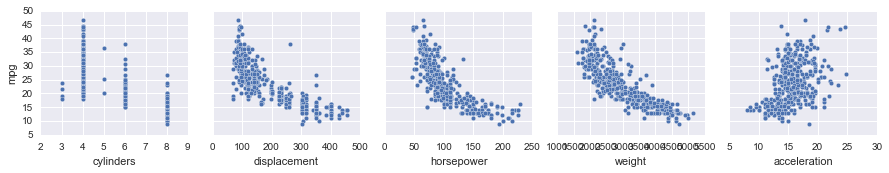

In [14]:
sns.pairplot(data=Auto, x_vars=['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration'],
             y_vars=['mpg'])

[28.803476282051282, 22.611229807692308, 22.609331267806262, 21.470917708333335, 20.811982615384615, 20.367053027065527, 20.128171755625328, 20.041370252403844, 19.819893819246595, 19.394037391025638, 19.665185473617292, 19.563558159722223, 19.534176505841298, 19.876876403061225, 19.782276683760685, 19.661657960236379, 19.750322194126518, 19.972799835786642, 20.137255788763408, 20.309922937499998, 20.233491753881044, 20.182864776700569, 20.24482632203965, 20.144384929220085, 20.172909699487178, 20.189357255158548, 20.290644758362351, 20.211118291306907, 20.136955111436329, 20.159061073361823, 20.039118865898235, 20.01849016363682, 19.973645135504224, 19.9423782971786, 19.900149684981688, 19.797433732490504, 19.781925943979321, 19.724867849279072, 19.761354710126604, 19.704481494391025]

min error K = 10


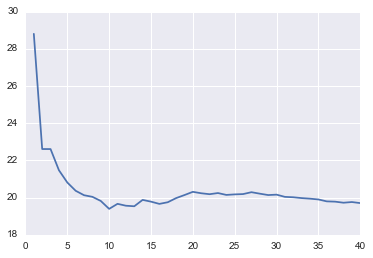

In [15]:
from sklearn.neighbors import KNeighborsRegressor
scores = []
X = Auto.loc[:, 'cylinders' : 'acceleration']
y = Auto.mpg
for k in range(1, 41):
    knn = KNeighborsRegressor(n_neighbors=k)
    mse_s = -cross_val_score(knn, X, y, cv=10, scoring='mean_squared_error')
    scores.append(mse_s.mean())
    
print(scores)   

plt.plot(range(1,41), scores )
print("\nmin error K = %d" % ( np.argmin(scores) +1 ) )    # scores : 0 indexed

- K를 1에서 40까지 변화해 가면서 각 K마다 10-fold Cross_validation을 해 보니, K=10 일 때 MSE가 가장 작음.  따라서 K=10으로 패러미터를 정하는 것이 타당
- 물론 이 모델, 이 K가 전체적으로 최적이라는 말은 아님. Feature들을 달리하던가, feature들을 전처리(standardization 등)을 하면 최적의 K가 달라질 수 있고, Cross-validation으로 얻는 test MSE 추정값도 달라 질 것임

### K-Fold Cross-Validation으로 Classifier 평가 : Classifier의 성능 지표 중 AUC를 계산
#### scikit-learn의 '[cross_val_score](http://scikit-learn.org/0.17/modules/generated/sklearn.cross_validation.cross_val_score.html#sklearn.cross_validation.cross_val_score)' 함수를 이용

In [16]:
# Classifier로 Logistic Regression을, 데이터로 Caravan 사용
Caravan = pd.read_csv('../Data/Caravan.csv', index_col=0)
Caravan = pd.get_dummies(Caravan, drop_first=True)   # 'Purchase_Yes' is positve 1

X = Caravan.drop(['Purchase_Yes'], axis=1)   #  response를 제외한 모든 변수들을 predictor로 삼음 
y = Caravan.Purchase_Yes

from sklearn.linear_model import LogisticRegression 
log_reg = LogisticRegression(solver='newton-cg')
cross_val_score(log_reg, X, y, cv=7, scoring='roc_auc').mean()    # give 'roc_auc' as the argument for 'scoring' 

0.74084663679136253

- 이 모델에서 threshold를 어디에서 잡아 sensitivity와 FPR간의 적절한 tradeoff를 결정할 지는 별개의 고려사항. 그렇지만 AUC가 크면 일단 유리한 것은 맞음  

#### Classification 모델에서의 Cross-Validation 활용 :  Feature Selection
85개나 되는 predictor들이 다 필요할까? Feature들을 많이 쓸수록 좋은 것은 아닐 터인데...

There's a little problem when employing K-CV's to a model with lots of predictors(and derivative terms) to systematically select predictors. It's about how we can efficiently reduce the search space and do it automatically so that we can finish the job within a reasonable time.

그런데 **문제가 있음**.  85개 predictor 중에 어느 것들을 추려야 하나?  또, predictor간의 interaction을 고려해야 하나? Predictor를 non-linear 변환해 적용할 수도 있는데, 그러면 그 조합들 수가 어떻게 되지? Correlation 관계를 보는 것이나 그 외 다른 방법도 이 경우엔 별 도움이 안될 듯. 6장에 있듯이 stepwise selection 등을 사용해 feature들을 선택하는 자동화된 방법이 있음. 하지만 cross-validation같이 널리 유연하게 사용할 수 있으면서 test performance를 직접적으로 추정하는 방법은 드뭄.

하나 하나의 조합 케이스에 Cross-Validation 방법을 적용하면 쓸만한 performance estimate을 구할 수 있음. 그렇지만 거기에 요구되는 시간은?  또, 어떻게 이런 다양한 조합들을 체계적이고 자동으로 탐색할 수 있는지?  

***이런 것들은 사람이 할 일이 아님! ***

#### scikit-learn은 이런 질문/요구에 적용할 수 있는 기초적인 체계적/자동화된 메커니즘을 제공함.   이런 기능을 이용해 자동화된 탐색/분석 절차나 시스템을 사람이 만들고...  



In [17]:
print('exit 0')

exit 0
